In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 21 21:08:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    52W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_encoder import Encoder
from model.latent.nonlinear_vqvae_latent import Latent
from model.decoder.dalle_decoder import Decoder
from model.no_module import NoModule

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.n_latents = 256
hp.z_dim = 512


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), NoModule(**hp), Latent(**hp), NoModule(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 18.6689453125
encoder.encoder 18.6689453125
prior 0.0
latent 180.0546875
latent.bottle 0.0
latent.linear 180.0546875
quantizer 0.0
decoder 9.954113006591797
decoder.decoder 9.954113006591797
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.21-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 17302, model_list, optimizer_list)

total 675604
-rw-rw-r-- 1 scpark scpark     14079  1월 21 21:07 events.out.tfevents.1705838650.GPUSVR11
-rw-rw-r-- 1 scpark scpark 657114545  1월 21 21:04 save_0
-rw-rw-r-- 1 scpark scpark    233545  1월 21 21:01 events.out.tfevents.1705837798.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 21 20:49 events.out.tfevents.1705837782.GPUSVR11
-rw-rw-r-- 1 scpark scpark   1714514  1월 21 20:49 events.out.tfevents.1705832858.GPUSVR11
-rw-rw-r-- 1 scpark scpark  16353895  1월 21 20:49 save_17302
-rw-rw-r-- 1 scpark scpark  16353895  1월 21 20:15 save_10000
-rw-rw-r-- 1 scpark scpark        40  1월 21 19:27 events.out.tfevents.1705832809.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

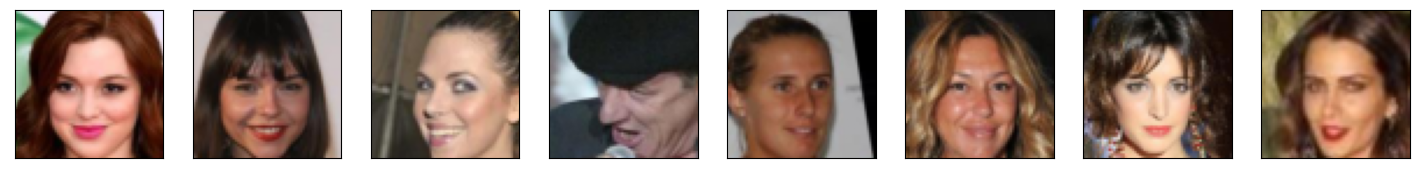

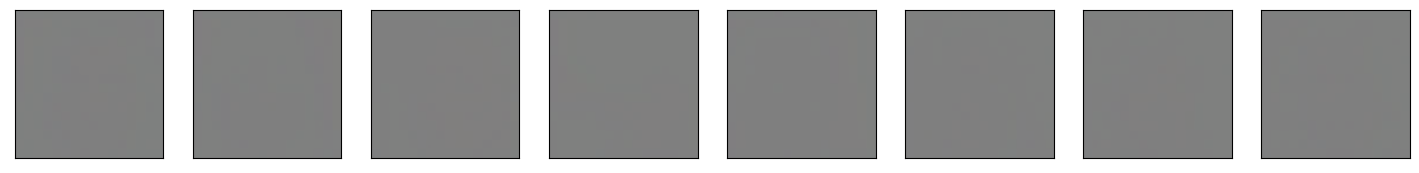

1
commit_loss 0.02269667573273182
recon_loss 0.08157110214233398
2
commit_loss 0.00989389419555664
recon_loss 0.07939855754375458
3
commit_loss 0.003638383001089096
recon_loss 0.07569846510887146
4
commit_loss 0.005453374236822128
recon_loss 0.07714933156967163
5
commit_loss 0.007324605248868465
recon_loss 0.06785698235034943
6
commit_loss 0.006188985891640186
recon_loss 0.07061076164245605
7
commit_loss 0.006893055979162455
recon_loss 0.05790345370769501
8
commit_loss 0.007561099715530872
recon_loss 0.05239717289805412
9
commit_loss 0.008064326830208302
recon_loss 0.04391743242740631
10
commit_loss 0.02514600194990635
recon_loss 0.04223619028925896
11
commit_loss 0.008138701319694519
recon_loss 0.0345270037651062
12
commit_loss 0.004139474127441645
recon_loss 0.039455756545066833
13
commit_loss 0.0031186097767204046
recon_loss 0.041244469583034515
14
commit_loss 0.0034247611183673143
recon_loss 0.024939721450209618
15
commit_loss 0.005569773726165295
recon_loss 0.02640426717698574
16


commit_loss 0.0006375202792696655
recon_loss 0.0073738498613238335
122
commit_loss 0.00045830808812752366
recon_loss 0.007582230027765036
123
commit_loss 0.000586008420214057
recon_loss 0.008023876696825027
124
commit_loss 0.00041677214903756976
recon_loss 0.007867144420742989
125
commit_loss 0.000596853788010776
recon_loss 0.006922935601323843
126
commit_loss 0.0006460014265030622
recon_loss 0.007596067152917385
127
commit_loss 0.000605665729381144
recon_loss 0.007908742874860764
128
commit_loss 0.000557374965865165
recon_loss 0.0074350847862660885
129
commit_loss 0.0007913765730336308
recon_loss 0.007933514192700386
130
commit_loss 0.0006325560971163213
recon_loss 0.00770428916439414
131
commit_loss 0.0005153066595084965
recon_loss 0.007852843031287193
132
commit_loss 0.00044331938261166215
recon_loss 0.006984672974795103
133
commit_loss 0.0004401667683850974
recon_loss 0.0068330480717122555
134
commit_loss 0.0005600025178864598
recon_loss 0.007405718322843313
135
commit_loss 0.00049

commit_loss 0.0004959995276294649
recon_loss 0.005808406975120306
239
commit_loss 0.00041218430851586163
recon_loss 0.0059687551110982895
240
commit_loss 0.00029747519874945283
recon_loss 0.005226476117968559
241
commit_loss 0.000348622037563473
recon_loss 0.005368123762309551
242
commit_loss 0.0005376697517931461
recon_loss 0.005626061465591192
243
commit_loss 0.00039100248250178993
recon_loss 0.005509153939783573
244
commit_loss 0.00037217416684143245
recon_loss 0.0053510214202106
245
commit_loss 0.0003621680079959333
recon_loss 0.0054028332233428955
246
commit_loss 0.000462232215795666
recon_loss 0.0056664785370230675
247
commit_loss 0.0004387330263853073
recon_loss 0.005484345834702253
248
commit_loss 0.0003652980085462332
recon_loss 0.005231891758739948
249
commit_loss 0.00047582582919858396
recon_loss 0.005931505933403969
250
commit_loss 0.0004094520700164139
recon_loss 0.005675605498254299
251
commit_loss 0.00040071853436529636
recon_loss 0.005380782764405012
252
commit_loss 0.0

commit_loss 0.00047417220775969326
recon_loss 0.005266634747385979
356
commit_loss 0.0003353955107741058
recon_loss 0.0053193881176412106
357
commit_loss 0.00036040175473317504
recon_loss 0.005230545066297054
358
commit_loss 0.0002988098713103682
recon_loss 0.004748339764773846
359
commit_loss 0.00031152309384196997
recon_loss 0.0051674493588507175
360
commit_loss 0.00035354268038645387
recon_loss 0.005641620606184006
361
commit_loss 0.0003348128229845315
recon_loss 0.0051794154569506645
362
commit_loss 0.00032667085179127753
recon_loss 0.005302391480654478
363
commit_loss 0.00035345155629329383
recon_loss 0.005134315229952335
364
commit_loss 0.0003888079081661999
recon_loss 0.005244359374046326
365
commit_loss 0.00038378569297492504
recon_loss 0.0058515798300504684
366
commit_loss 0.0003680944791994989
recon_loss 0.006232886575162411
367
commit_loss 0.0003459540894255042
recon_loss 0.0063720447942614555
368
commit_loss 0.0003817940014414489
recon_loss 0.00587053969502449
369
commit_lo

commit_loss 0.0003316841321066022
recon_loss 0.005316551774740219
473
commit_loss 0.00042315881000831723
recon_loss 0.004894737154245377
474
commit_loss 0.0003204290405847132
recon_loss 0.0051040081307291985
475
commit_loss 0.0003664810792542994
recon_loss 0.005190417170524597
476
commit_loss 0.0003258528304286301
recon_loss 0.005476014222949743
477
commit_loss 0.0003639917995315045
recon_loss 0.005040623247623444
478
commit_loss 0.00028953843866474926
recon_loss 0.0048581138253211975
479
commit_loss 0.0002939964469987899
recon_loss 0.005137810483574867
480
commit_loss 0.0003162155917380005
recon_loss 0.004805371165275574
481
commit_loss 0.0003249497094657272
recon_loss 0.005363815929740667
482
commit_loss 0.00041051075095310807
recon_loss 0.005210998468101025
483
commit_loss 0.000344224477885291
recon_loss 0.005249337758868933
484
commit_loss 0.0003658384957816452
recon_loss 0.005169650074094534
485
commit_loss 0.00034304772270843387
recon_loss 0.005195326637476683
486
commit_loss 0.0

commit_loss 0.00030738208442926407
recon_loss 0.005130713805556297
590
commit_loss 0.00034738704562187195
recon_loss 0.004864574410021305
591
commit_loss 0.000242319714743644
recon_loss 0.004915430210530758
592
commit_loss 0.00027216842863708735
recon_loss 0.005103877279907465
593
commit_loss 0.0003149238764308393
recon_loss 0.0056344992481172085
594
commit_loss 0.00023256411077454686
recon_loss 0.0048087346367537975
595
commit_loss 0.00030975748086348176
recon_loss 0.004864796996116638
596
commit_loss 0.0003201472572982311
recon_loss 0.005137329921126366
597
commit_loss 0.00025657619698904455
recon_loss 0.004537375643849373
598
commit_loss 0.00026868193526752293
recon_loss 0.004466414917260408
599
commit_loss 0.0003048819780815393
recon_loss 0.004898422863334417
600
commit_loss 0.0002766399993561208
recon_loss 0.005095710977911949
601
commit_loss 0.0002490454353392124
recon_loss 0.005194629542529583
602
commit_loss 0.000326423003571108
recon_loss 0.005206112749874592
603
commit_loss 0

commit_loss 0.00031071901321411133
recon_loss 0.004513855092227459
707
commit_loss 0.00028066153754480183
recon_loss 0.005228450056165457
708
commit_loss 0.0003432916710153222
recon_loss 0.004937437828630209
709
commit_loss 0.0003165054367855191
recon_loss 0.004706885199993849
710
commit_loss 0.00033355344203300774
recon_loss 0.004772772081196308
711
commit_loss 0.0002990742796100676
recon_loss 0.004811324179172516
712
commit_loss 0.0003401303256396204
recon_loss 0.005117155145853758
713
commit_loss 0.0003414801321923733
recon_loss 0.005160513333976269
714
commit_loss 0.00031803749152459204
recon_loss 0.005036515649408102
715
commit_loss 0.00030580899328924716
recon_loss 0.004831232596188784
716
commit_loss 0.0002887110167648643
recon_loss 0.004561907611787319
717
commit_loss 0.0002964028681162745
recon_loss 0.004957592114806175
718
commit_loss 0.0003256202326156199
recon_loss 0.004769747611135244
719
commit_loss 0.0003304762067273259
recon_loss 0.004927126225084066
720
commit_loss 0.0

commit_loss 0.0003051504900213331
recon_loss 0.0048616318963468075
824
commit_loss 0.00031816400587558746
recon_loss 0.005046759732067585
825


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            def get_entropy(zi):
                # (N, L)
                zi_onehot = F.one_hot(zi, num_classes=hp.n_latents)
                # (L)
                probs = zi_onehot.sum(dim=0) / len(zi_onehot)
                entropy = torch.sum(-probs * (torch.log(torch.clamp(probs, 1e-8)) - np.log(2)))
                return entropy

            entropy = get_entropy(data['zi']).item()
            writer.add_scalar('entropy', entropy, step)            
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
data.keys()